# Importing speech sentiments from Colab notebook

In [8]:
import pandas as pd
sentiments = pd.read_csv("src/Data/speech_all_finbert.csv").drop(columns=["Unnamed: 0"])
sentiments['info_channel'] = 'speech'
sentiments

,date,content,sentiment,probability,info_channel
0,1998-07-17,Mr. Duisenberg reports on the outcome of the s...,positive,0.854208,speech
1,1998-07-17,Economic growth has been driven increasingly b...,positive,0.947828,speech
2,1998-07-17,"In principle, the economic performance I have ...",neutral,0.600082,speech
3,1998-07-17,"Third, further structural adjustments in fisca...",neutral,0.824068,speech
4,1998-07-17,There is currently no sign of exchange rate te...,neutral,0.756298,speech
...,...,...,...,...,...
46014,2022-02-25,Since the exchange of confidential information...,positive,0.664321,speech
46015,2022-02-25,"Last year, following discussions in the Counci...",neutral,0.762738,speech
46016,2022-02-25,This type of measure has so far only been impl...,neutral,0.897179,speech
46017,2022-02-25,The ECB incorporated in its opinions its exper...,neutral,0.868921,speech


In [9]:
import pandas as pd

def generalize_sentiments(df):
    """
    Generalizes the sentiments of a dataframe by consolidating rows with the same date.
    It aggregates content by date, computes sentiment counts, and calculates max, min, and average 
    probabilities for each sentiment type (positive, negative, neutral).

    Parameters:
    - df (pandas.DataFrame): DataFrame containing 'date', 'content', 'sentiment', 
                             and respective sentiment probabilities columns.

    Returns:
    - pandas.DataFrame: DataFrame with consolidated content and aggregated sentiment metrics.
    """
    
    # Convert content to string to avoid TypeError and concatenate for rows with the same date
    consolidated_content = df.groupby('date')['content'].apply(lambda x: ' '.join(map(str, x))).reset_index()

    # Compute sentiment counts for each date
    sentiment_counts = df.groupby(['date', 'sentiment']).size().unstack().reset_index().fillna(0)
    sentiment_counts.columns = ['date'] + [f"{col.lower()}_counts" for col in sentiment_counts.columns if col != 'date']

    # Compute max, min, and average probabilities for each sentiment by date
    aggregations = {}
    for sentiment in ['positive', 'negative', 'neutral']:
        mask = df['sentiment'] == sentiment
        aggregated = df[mask].groupby('date').agg({
            'probability': ['max', 'min', 'mean']
        }).reset_index()
        
        # Flatten the multi-index column names
        aggregated.columns = ['date'] + [f"{sentiment}_{metric}" for metric in ['max', 'min', 'mean']]
        aggregations[sentiment] = aggregated

    # Merge the created dataframes to generate the final output
    result = consolidated_content
    result = pd.merge(result, sentiment_counts, on='date', how='inner')
    for sentiment in ['positive', 'negative', 'neutral']:
        result = pd.merge(result, aggregations[sentiment], on='date', how='inner')

    return result


In [11]:
gen_data = generalize_sentiments(sentiments)
gen_data['weighted_prob'] = (gen_data['negative_counts'] * gen_data['negative_mean'] * (-1) + gen_data['positive_counts'] * gen_data['positive_mean'] ) / (gen_data['negative_counts']+gen_data['positive_counts'])
gen_data['info_channel'] = 'speech'
gen_data

,date,content,negative_counts,neutral_counts,positive_counts,positive_max,positive_min,positive_mean,negative_max,negative_min,negative_mean,neutral_max,neutral_min,neutral_mean,weighted_prob,info_channel
0,1998-11-09,Mr. Duisenberg’s opening statement at the pres...,6.0,13.0,2.0,0.899266,0.765561,0.832413,0.962060,0.523458,0.785708,0.948906,0.531514,0.870117,-0.381178,speech
1,1998-12-03,Mr Duisenberg reports on the current position ...,2.0,14.0,3.0,0.808924,0.565346,0.677796,0.847879,0.645703,0.746791,0.952718,0.680924,0.828251,0.107961,speech
2,1999-01-08,Mr Duisenberg’s opening statement at the press...,2.0,18.0,2.0,0.923603,0.554621,0.739112,0.947072,0.880715,0.913893,0.949159,0.535464,0.845749,-0.087391,speech
3,1999-01-11,Mr Duisenberg’s opening statement at the press...,10.0,23.0,2.0,0.817296,0.668759,0.743027,0.954375,0.496729,0.723577,0.950720,0.375282,0.818889,-0.479143,speech
4,1999-01-19,Mr Duisenberg’s opening statement at the Europ...,6.0,16.0,2.0,0.870406,0.866672,0.868539,0.968294,0.739333,0.871450,0.946656,0.559591,0.827322,-0.436452,speech
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,2022-01-21,Christine Lagarde: Introductory statement at t...,1.0,7.0,10.0,0.953582,0.613189,0.747925,0.466378,0.466378,0.466378,0.839482,0.542453,0.744504,0.637534,speech
1248,2022-02-04,Christine Lagarde: Introductory statement at E...,4.0,1.0,4.0,0.954398,0.446699,0.824757,0.943139,0.491753,0.756767,0.539072,0.539072,0.539072,0.033995,speech
1249,2022-02-10,Christine Lagarde: Hearing of the Committee on...,4.0,5.0,3.0,0.953364,0.543439,0.779126,0.943748,0.461614,0.703850,0.872223,0.506347,0.692795,-0.068289,speech
1250,2022-02-17,Christine Lagarde: Introductory statement - Eu...,3.0,8.0,5.0,0.946285,0.534803,0.763456,0.928384,0.727196,0.845817,0.895302,0.626179,0.816141,0.159978,speech


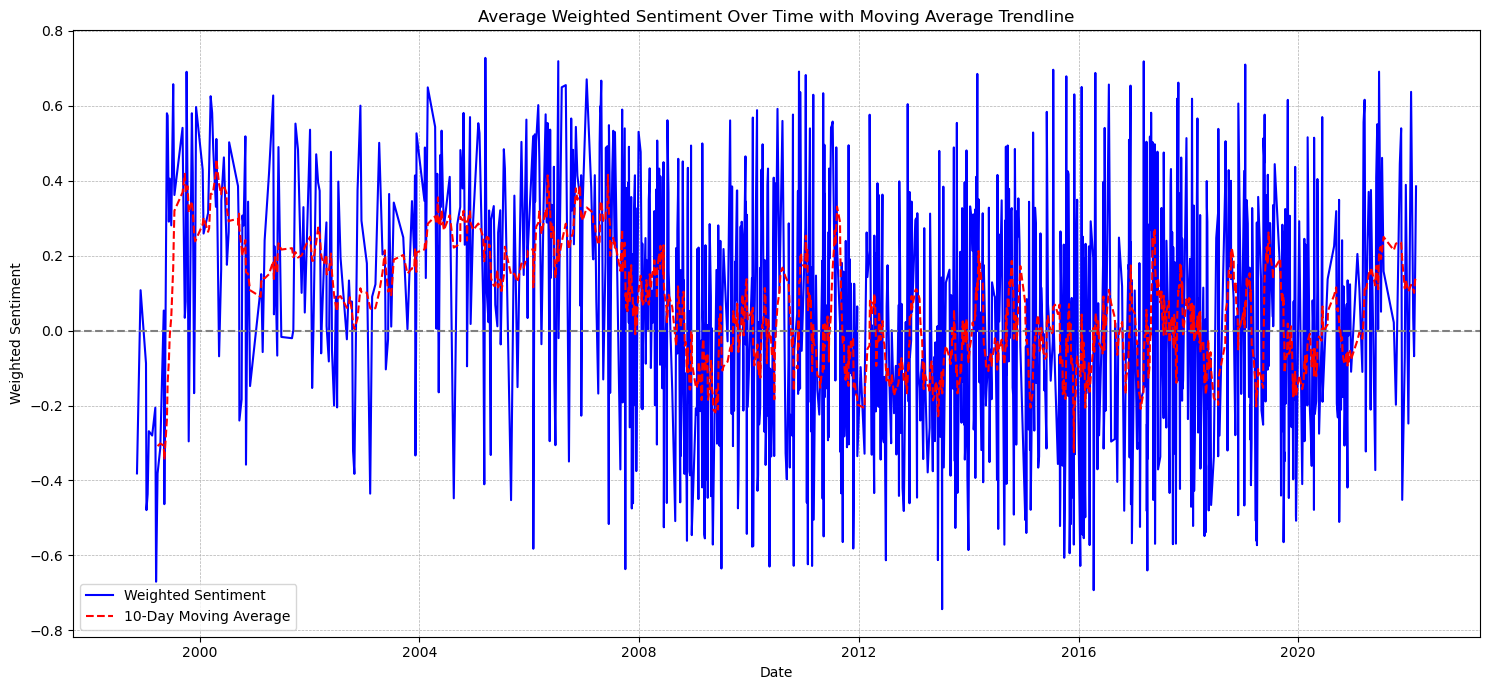

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming gen_data is your dataframe
# Convert the date column to datetime type for better plotting
gen_data['date'] = pd.to_datetime(gen_data['date'])

# Calculate the moving average. Adjust the window size as needed.
window_size = 10  # Adjust this as per your preference
gen_data['moving_avg'] = gen_data['weighted_prob'].rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(15,7))
plt.plot(gen_data['date'], gen_data['weighted_prob'], label='Weighted Sentiment', color='blue')
plt.plot(gen_data['date'], gen_data['moving_avg'], "r--", label=f'{window_size}-Day Moving Average')
plt.axhline(y=0, color='grey', linestyle='--')  # A line at y=0 for reference

plt.title('Average Weighted Sentiment Over Time with Moving Average Trendline')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


# Bring other time series variables

In [7]:
import yfinance as yf
import pandas as pd

# Define the path to your data file
data_path = "src/Data/stoxx.txt"

# Read the data file into a DataFrame
vstoxx_df = pd.read_csv(data_path, delimiter=";", parse_dates=["Date"], dayfirst=True)

# Change the date format to DD-MM-YYYY
vstoxx_df["Date_merge"] = vstoxx_df["Date"].dt.strftime("%d-%m-%Y")

# generate day of the week column
vstoxx_df['day_of_week'] = pd.to_datetime(vstoxx_df['Date']).dt.day_name()

# generate month column
vstoxx_df['month'] = pd.to_datetime(vstoxx_df['Date']).dt.month_name()

# calculate the daily change in the index
vstoxx_df['delta_daily'] = vstoxx_df['Indexvalue'].diff()
#vstoxx_df['delta_3d'] = vstoxx_df['Indexvalue'].diff(3)
#vstoxx_df['delta_5d'] = vstoxx_df['Indexvalue'].diff(5)
#vstoxx_df['delta_30d'] = vstoxx_df['Indexvalue'].diff(30)
#vstoxx_df['3d_pp_change'] = vstoxx_df['Indexvalue'].pct_change(3)
vstoxx_df['shifted_1_day'] = vstoxx_df['Indexvalue'].shift(-2)
vstoxx_df['delta_shifted'] = vstoxx_df['Indexvalue'] - vstoxx_df['shifted_1_day']
vstoxx_df['delta_shifted_2'] = vstoxx_df['delta_shifted'].shift(1)
# Display the DataFrame
vstoxx_df


,Date,Symbol,Indexvalue,Date_merge,day_of_week,month,delta_daily,shifted_1_day,delta_shifted,delta_shifted_2
0,1999-01-04,V2TX,18.2033,04-01-1999,Monday,January,NaN,25.1670,-6.9637,NaN
1,1999-01-05,V2TX,29.6912,05-01-1999,Tuesday,January,11.4879,32.5205,-2.8293,-6.9637
2,1999-01-06,V2TX,25.1670,06-01-1999,Wednesday,January,-4.5242,33.2296,-8.0626,-2.8293
3,1999-01-07,V2TX,32.5205,07-01-1999,Thursday,January,7.3535,36.8411,-4.3206,-8.0626
4,1999-01-08,V2TX,33.2296,08-01-1999,Friday,January,0.7091,37.5664,-4.3368,-4.3206
...,...,...,...,...,...,...,...,...,...,...
6268,2023-08-15,V2TX,18.8579,15-08-2023,Tuesday,August,0.8050,20.3539,-1.4960,-0.4981
6269,2023-08-16,V2TX,18.5510,16-08-2023,Wednesday,August,-0.3069,20.2456,-1.6946,-1.4960
6270,2023-08-17,V2TX,20.3539,17-08-2023,Thursday,August,1.8029,19.8367,0.5172,-1.6946
6271,2023-08-18,V2TX,20.2456,18-08-2023,Friday,August,-0.1083,NaN,NaN,0.5172


# Bond price data

In [13]:
# Bond prices

# Define the ticker symbol for the Eurozone bond you're interested in
bond_ticker = ["DAX"]

# Define the start and end dates for the data you want to fetch
start_date = "2000-01-01"
end_date = "2023-08-01"

# Fetch the bond price data using yfinance
bond_data = yf.download(bond_ticker, start=start_date, end=end_date)

# remove the 1st row for Date, and keep it in 0th row
bond_data.reset_index(inplace=True)

# keep only date and adjusted close columns
bond_data = bond_data[['Date','Adj Close']]
bond_data.columns = ['Date', 'bond_price']

# generate more variables
bond_data['b_delta_daily'] = bond_data['bond_price'].diff()
bond_data['b_delta_3d'] = bond_data['bond_price'].diff(3)
bond_data['b_delta_5d'] = bond_data['bond_price'].diff(5)
bond_data['b_delta_30d'] = bond_data['bond_price'].diff(30)
bond_data['b_3d_pp_change'] = bond_data['bond_price'].pct_change(3)

# Display the downloaded data
bond_data

[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_8169/241225619.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bond_data['b_delta_daily'] = bond_data['bond_price'].diff()
/tmp/ipykernel_8169/241225619.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bond_data['b_delta_3d'] = bond_data['bond_price'].diff(3)
/tmp/ipykernel_8169/241225619.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,Date,bond_price,b_delta_daily,b_delta_3d,b_delta_5d,b_delta_30d,b_3d_pp_change
0,2014-10-23,20.524279,NaN,NaN,NaN,NaN,NaN
1,2014-10-24,20.475506,-0.048773,NaN,NaN,NaN,NaN
2,2014-10-27,20.343826,-0.131680,NaN,NaN,NaN,NaN
3,2014-10-28,20.735620,0.391794,0.211342,NaN,NaN,0.010297
4,2014-10-29,20.865673,0.130053,0.390167,NaN,NaN,0.019055
...,...,...,...,...,...,...,...
2201,2023-07-25,30.100000,0.130001,-0.049999,-0.309999,1.268011,-0.001658
2202,2023-07-26,30.080000,-0.020000,-0.070000,-0.240000,0.866453,-0.002322
2203,2023-07-27,30.000000,-0.080000,0.030001,-0.150000,0.590784,0.001001
2204,2023-07-28,30.490000,0.490000,0.389999,0.340000,0.982948,0.012957


# Euro yield curve

In [29]:
# import the yield curve data
yield_curve = pd.read_csv("src/Data/euro_yield_curve.csv")

# Select only 'date' and 's1' columns
yield_curve = yield_curve[['date', 's1']]

# Rename the 's1' column to 's1_yield'
yield_curve.rename(columns={'s1': 's1_yield'}, inplace=True)

yield_curve 

,date,s1_yield
0,2004-09-06,3.298175
1,2004-09-07,3.338711
2,2004-09-08,3.375993
3,2004-09-09,3.284360
4,2004-09-10,3.208441
...,...,...
4843,2023-08-14,2.370727
4844,2023-08-15,2.448853
4845,2023-08-16,2.428063
4846,2023-08-17,2.466451


# Labor and umemployment data

In [20]:
# import and transform the data for labor productivity
labor = pd.read_csv("src/Data/Labor_productivity.csv")

# import and transform the data for unemployment
unemployment = pd.read_csv("src/Data/Unemployment.csv")


In [27]:
unemployment

,date,conf,status1,s1
0,2000-01-31,NaN,Normal value,9.44
1,2000-02-29,NaN,Normal value,9.35
2,2000-03-31,NaN,Normal value,9.26
3,2000-04-30,NaN,Normal value,9.18
4,2000-05-31,NaN,Normal value,9.12
...,...,...,...,...
277,2023-02-28,NaN,Normal value,6.59
278,2023-03-31,NaN,Normal value,6.52
279,2023-04-30,NaN,Normal value,6.45
280,2023-05-31,NaN,Normal value,6.40


In [21]:
# Adjust the time and increment the date
def adjust_time(date_string):
    if '24:00:00' in date_string:
        date_string = date_string.replace('24:00:00', '00:00:00')
        date_object = pd.to_datetime(date_string) + pd.Timedelta(days=1)
        return date_object.date()
    else:
        return pd.to_datetime(date_string).date()

labor['date'] = labor['date'].apply(adjust_time)
unemployment['date'] = unemployment['date'].apply(adjust_time)

In [25]:
# Merge the dataframes using an outer join and suffixes for columns from each dataframe
labor_unemployment = pd.merge(labor[['date', 's1']], unemployment[['date', 's1']], on='date', how='outer', suffixes=('_labor', '_unemployment'))

# Rename the columns for clarity
labor_unemployment.rename(columns={'s1_labor': 'labor_prod_s1', 's1_unemployment': 'unemployment_s1'}, inplace=True)
labor_unemployment

,date,labor_prod_s1,unemployment_s1
0,1999-03-31,0.22,NaN
1,1999-06-30,0.38,NaN
2,1999-09-30,1.01,NaN
3,1999-12-31,2.01,NaN
4,2000-03-31,1.96,9.26
...,...,...,...
281,2022-11-30,NaN,6.68
282,2023-01-31,NaN,6.67
283,2023-02-28,NaN,6.59
284,2023-04-30,NaN,6.45


# Dax data

In [38]:
import yfinance as yf
import pandas as pd

# Define the ticker symbols and the date range
ticker_dax = "DAX"
ticker_vdax = "^VDAX"
start_date = "1999-01-01"
end_date = "2022-12-31"

# Fetch data for DAX
dax_data = yf.download(ticker_dax, start=start_date, end=end_date)

# Fetch data for VDAX
vdax_data = yf.download(ticker_vdax, start=start_date, end=end_date)

# Create a single DataFrame by merging on Date
dax_selected = pd.merge(dax_data[['Close', 'Volume']], vdax_data[['Close', 'Volume']], left_index=True, right_index=True, how='outer', suffixes=('_dax', '_vdax'))

# Rename columns
dax_selected.columns = ['Close_dax', 'Volume_dax', 'Close_vdax', 'Volume_vdax']

# Reset index to have Date as a column
dax_selected = dax_selected.reset_index().rename(columns={"index": "Date"})

dax_selected

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,Close_dax,Volume_dax,Close_vdax,Volume_vdax
0,2005-11-16,NaN,NaN,14.65,0.0
1,2005-11-17,NaN,NaN,14.54,0.0
2,2005-11-18,NaN,NaN,14.35,0.0
3,2005-11-21,NaN,NaN,13.56,0.0
4,2005-11-22,NaN,NaN,13.69,0.0
...,...,...,...,...,...
4269,2022-12-23,25.60,1400.0,NaN,NaN
4270,2022-12-27,25.77,8800.0,NaN,NaN
4271,2022-12-28,25.49,18200.0,NaN,NaN
4272,2022-12-29,26.15,13500.0,NaN,NaN


# Merge all of them into one


In [40]:
# Convert all 'Date' columns to datetime format
dax_selected['Date'] = pd.to_datetime(dax_selected['Date'])
labor_unemployment['Date'] = pd.to_datetime(labor_unemployment['Date'])
yield_curve['Date'] = pd.to_datetime(yield_curve['Date'])
bond_data['Date'] = pd.to_datetime(bond_data['Date'])
vstoxx_df['Date'] = pd.to_datetime(vstoxx_df['Date'])
gen_data['Date'] = pd.to_datetime(gen_data['Date'])

# Now, proceed with the merge
merged_df = dax_selected.merge(labor_unemployment, on='Date', how='outer')
merged_df = merged_df.merge(yield_curve, on='Date', how='outer')
merged_df = merged_df.merge(bond_data, on='Date', how='outer')
merged_df = merged_df.merge(vstoxx_df, on='Date', how='outer')
merged_df = merged_df.merge(gen_data, on='Date', how='outer')

# Examine the resulting dataframe
print(merged_df.head())
print(merged_df.shape)


        Date  Close_dax  Volume_dax  Close_vdax  Volume_vdax  labor_prod_s1  \
0 2005-11-16        NaN         NaN       14.65          0.0            NaN   
1 2005-11-17        NaN         NaN       14.54          0.0            NaN   
2 2005-11-18        NaN         NaN       14.35          0.0            NaN   
3 2005-11-21        NaN         NaN       13.56          0.0            NaN   
4 2005-11-22        NaN         NaN       13.69          0.0            NaN   

   unemployment_s1  s1_yield  bond_price  b_delta_daily  ...  positive_mean  \
0              NaN  2.904758         NaN            NaN  ...            NaN   
1              NaN  2.949934         NaN            NaN  ...            NaN   
2              NaN  3.069669         NaN            NaN  ...            NaN   
3              NaN  3.063077         NaN            NaN  ...            NaN   
4              NaN  3.024579         NaN            NaN  ...            NaN   

   negative_max  negative_min  negative_mean neutr

In [42]:
merged_df.columns.tolist()


['Date',
 'Close_dax',
 'Volume_dax',
 'Close_vdax',
 'Volume_vdax',
 'labor_prod_s1',
 'unemployment_s1',
 's1_yield',
 'bond_price',
 'b_delta_daily',
 'b_delta_3d',
 'b_delta_5d',
 'b_delta_30d',
 'b_3d_pp_change',
 'Symbol',
 'Indexvalue',
 'Date_merge',
 'day_of_week',
 'month',
 'delta_daily',
 'shifted_1_day',
 'delta_shifted',
 'delta_shifted_2',
 'content',
 'negative_counts',
 'neutral_counts',
 'positive_counts',
 'positive_max',
 'positive_min',
 'positive_mean',
 'negative_max',
 'negative_min',
 'negative_mean',
 'neutral_max',
 'neutral_min',
 'neutral_mean',
 'weighted_prob',
 'info_channel',
 'moving_avg']

In [43]:
# Count NaN and null values for each column
nan_counts = merged_df.isna().sum()

# Convert to DataFrame for better presentation
nan_table = pd.DataFrame(nan_counts, columns=['NaN/Null Count'])

print(nan_table)


                 NaN/Null Count
Date                          0
Close_dax                  4346
Volume_dax                 4346
Close_vdax                 3758
Volume_vdax                3758
labor_prod_s1              6310
unemployment_s1            6126
s1_yield                   1560
bond_price                 4202
b_delta_daily              4203
b_delta_3d                 4205
b_delta_5d                 4207
b_delta_30d                4232
b_3d_pp_change             4205
Symbol                      135
Indexvalue                  135
Date_merge                  135
day_of_week                 135
month                       135
delta_daily                 136
shifted_1_day               137
delta_shifted               137
delta_shifted_2             137
content                    5156
negative_counts            5156
neutral_counts             5156
positive_counts            5156
positive_max               5156
positive_min               5156
positive_mean              5156
negative

In [44]:
columns_to_fill = [
    'Close_dax',
    'Volume_dax',
    'Close_vdax',
    'Volume_vdax',
    'labor_prod_s1',
    'unemployment_s1',
    's1_yield',
    'bond_price',
    'b_delta_daily',
    'Indexvalue'
]

for column in columns_to_fill:
    merged_df[column] = merged_df[column].fillna(method='ffill')

merged_df

,Date,Close_dax,Volume_dax,Close_vdax,Volume_vdax,labor_prod_s1,unemployment_s1,s1_yield,bond_price,b_delta_daily,...,positive_mean,negative_max,negative_min,negative_mean,neutral_max,neutral_min,neutral_mean,weighted_prob,info_channel,moving_avg
0,2005-11-16,NaN,NaN,14.65,0.0,NaN,NaN,2.904758,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-11-17,NaN,NaN,14.54,0.0,NaN,NaN,2.949934,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-11-18,NaN,NaN,14.35,0.0,NaN,NaN,3.069669,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-11-21,NaN,NaN,13.56,0.0,NaN,NaN,3.063077,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-11-22,NaN,NaN,13.69,0.0,NaN,NaN,3.024579,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6403,1998-11-09,25.6,30200.0,17.92,0.0,-0.77,6.4,2.326963,29.663588,0.02935,...,0.832413,0.962060,0.523458,0.785708,0.948906,0.531514,0.870117,-0.381178,speech,NaN
6404,1998-12-03,25.6,30200.0,17.92,0.0,-0.77,6.4,2.326963,29.663588,0.02935,...,0.677796,0.847879,0.645703,0.746791,0.952718,0.680924,0.828251,0.107961,speech,NaN
6405,2004-05-08,25.6,30200.0,17.92,0.0,-0.77,6.4,2.326963,29.663588,0.02935,...,0.561009,0.925727,0.814508,0.890389,0.848415,0.594600,0.701783,-0.164690,speech,0.286782
6406,2020-02-23,25.6,30200.0,17.92,0.0,-0.77,6.4,2.326963,29.663588,0.02935,...,0.773739,0.965907,0.508479,0.787841,0.938106,0.461432,0.792334,-0.137183,speech,-0.119296


In [49]:
# Filter the rows based on the 'Date' column
merged_df = merged_df[merged_df['Date'] > '2005-01-01']

# filter and keep only where weighted_prob	exists
merged_df = merged_df[merged_df['weighted_prob'].notna()]

# Count NaN and null values for each column
nan_counts = merged_df.isna().sum()

# Convert to DataFrame for better presentation
nan_table = pd.DataFrame(nan_counts, columns=['NaN/Null Count'])

nan_table


,NaN/Null Count
Date,0
Close_dax,586
Volume_dax,586
Close_vdax,0
Volume_vdax,0
labor_prod_s1,11
unemployment_s1,0
s1_yield,0
bond_price,586
b_delta_daily,587


In [50]:
merged_df

,Date,Close_dax,Volume_dax,Close_vdax,Volume_vdax,labor_prod_s1,unemployment_s1,s1_yield,bond_price,b_delta_daily,...,positive_mean,negative_max,negative_min,negative_mean,neutral_max,neutral_min,neutral_mean,weighted_prob,info_channel,moving_avg
17,2005-12-12,NaN,NaN,13.04,0.0,NaN,9.1,2.994022,NaN,NaN,...,0.691991,0.594207,0.594207,0.594207,0.932836,0.613749,0.802728,0.563371,speech,0.192087
23,2005-12-20,NaN,NaN,12.85,0.0,NaN,9.1,3.009004,NaN,NaN,...,0.718270,0.951564,0.698058,0.879215,0.947499,0.436811,0.803184,0.033634,speech,0.199128
24,2005-12-21,NaN,NaN,12.55,0.0,NaN,9.1,3.062166,NaN,NaN,...,0.772336,0.851873,0.622102,0.717326,0.907337,0.523447,0.793781,0.213713,speech,0.213734
47,2006-01-26,NaN,NaN,14.52,0.0,NaN,9.1,3.137711,NaN,NaN,...,0.683034,0.956220,0.956220,0.956220,0.940607,0.551607,0.823517,0.519109,speech,0.217210
48,2006-01-27,NaN,NaN,14.55,0.0,NaN,9.1,3.172167,NaN,NaN,...,0.628309,0.946271,0.549009,0.768540,0.898706,0.371356,0.727104,-0.582294,speech,0.115711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4816,2019-02-18,25.6,30200.0,17.92,0.0,-0.77,6.4,-0.526818,28.166712,-0.587009,...,0.666040,0.917663,0.501889,0.769557,0.873136,0.616395,0.784554,-0.291025,speech,0.081589
4822,2020-02-17,25.6,30200.0,17.92,0.0,-0.77,6.4,-0.698982,28.166712,-0.587009,...,0.571220,0.794231,0.475922,0.615687,0.937393,0.378233,0.758561,-0.140924,speech,-0.103287
4829,2021-07-05,25.6,30200.0,17.92,0.0,-0.77,6.4,-0.687303,28.166712,-0.587009,...,0.753872,0.936251,0.530880,0.769947,0.867052,0.516707,0.687934,0.050571,speech,0.191339
6406,2020-02-23,25.6,30200.0,17.92,0.0,-0.77,6.4,2.326963,29.663588,0.029350,...,0.773739,0.965907,0.508479,0.787841,0.938106,0.461432,0.792334,-0.137183,speech,-0.119296


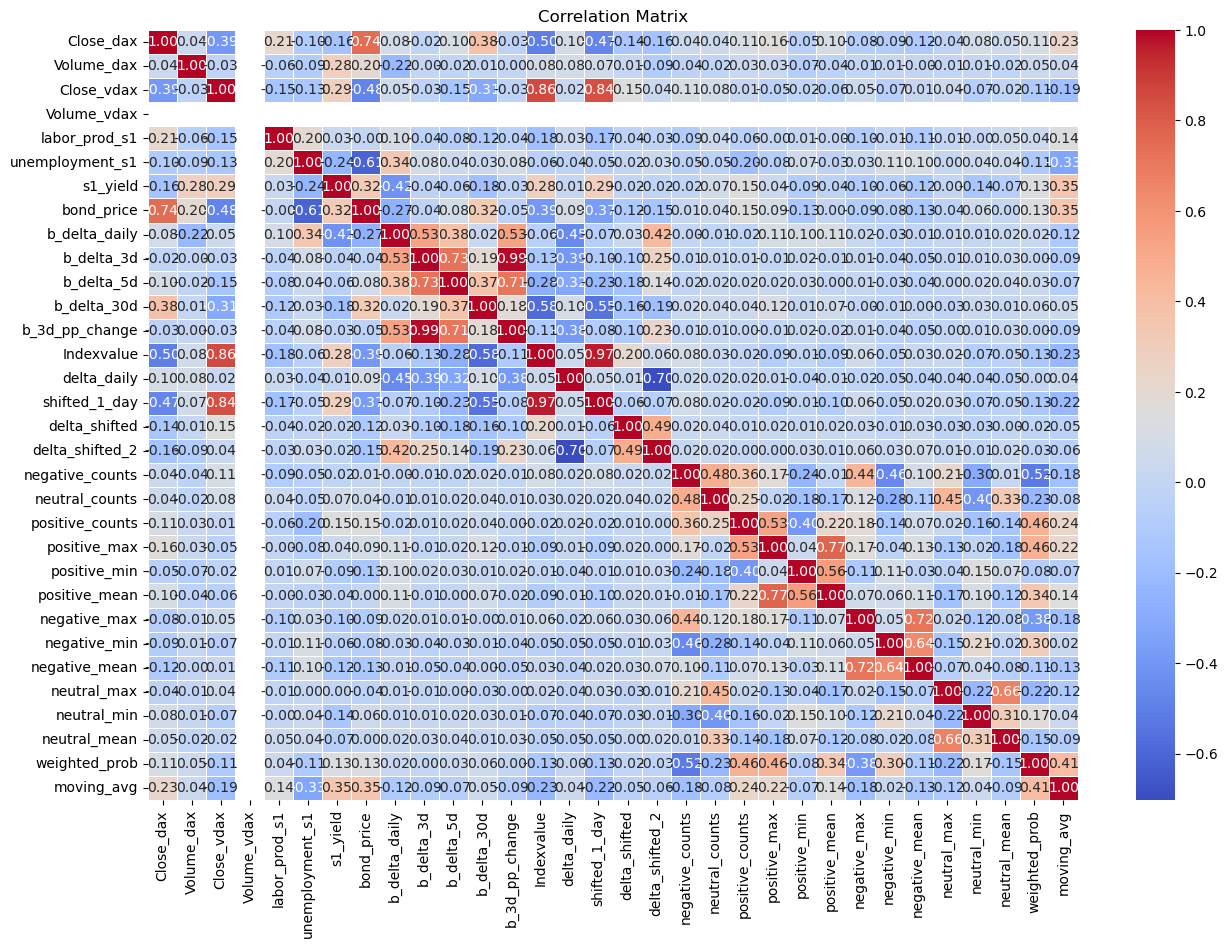

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Keep only numeric columns
numeric_cols = merged_df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [53]:
# Compute correlations of each column against 'weighted_prob'
correlations = {}
for col in merged_df.columns:
    if merged_df[col].dtype in ['float64', 'int64'] and col != 'weighted_prob':
        correlations[col] = merged_df[col].corr(merged_df['weighted_prob'])

# Convert dictionary to a DataFrame for better visualization and sorting
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Variable', 'Correlation_with_weighted_prob'])

# Sort by the absolute value of correlation to get a ranking
correlation_df['Abs_Correlation'] = correlation_df['Correlation_with_weighted_prob'].abs()
correlation_df = correlation_df.sort_values(by='Abs_Correlation', ascending=False).drop('Abs_Correlation', axis=1)

# Display the ranked correlations
print(correlation_df)


           Variable  Correlation_with_weighted_prob
18  negative_counts                       -0.518381
20  positive_counts                        0.462270
21     positive_max                        0.461506
30       moving_avg                        0.409274
24     negative_max                       -0.380445
23    positive_mean                        0.344238
25     negative_min                        0.297973
19   neutral_counts                       -0.226888
27      neutral_max                       -0.224788
28      neutral_min                        0.167157
29     neutral_mean                       -0.145156
7        bond_price                        0.132005
6          s1_yield                        0.131406
13       Indexvalue                       -0.129442
15    shifted_1_day                       -0.126250
5   unemployment_s1                       -0.114555
26    negative_mean                       -0.109218
0         Close_dax                        0.108451
2        Clo

# LSTM model with proper data preprocessing

In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Extract and normalize relevant columns
features = merged_df[['bond_price', 'weighted_prob', 's1_yield', 'Indexvalue', 'Close_dax']].dropna()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

# Convert data to 3D array format
X = []
y = []

for i in range(60, len(scaled_data)):  # Assuming a sequence length of 60
    X.append(scaled_data[i-60:i, 1:]) # All columns except 'bond_price'
    y.append(scaled_data[i, 0]) # 'bond_price' column

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 4)) # 4 predictor features

2023-09-24 12:10:14.097547: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-24 12:10:14.474601: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-24 12:10:16.639099: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-24 12:10:16.648682: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 12:10:22.401771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [71]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

# Assuming 'features' and 'targets' are already created and split as X and y, respectively.

# Split data (80% train, 20% test)
train_size = int(0.8 * X.shape[0])
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 4)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64)

# Evaluate model
predicted_bond_price = model.predict(X_test)

# Assuming your initial feature shape was 5 (including bond_price)
n_features = 5

# Make an array of zeros with the shape of (n_samples, n_features)
temp_array = np.zeros((predicted_bond_price.shape[0], n_features))

# Replace the first column (corresponding to bond_price) with your predictions
temp_array[:, 0] = predicted_bond_price.ravel()

# Now inverse transform this array
inverse_transformed = scaler.inverse_transform(temp_array)

# Extract the bond_price predictions from the first column
final_predicted_bond_price = inverse_transformed[:, 0]


Epoch 1/50


In [68]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Access training and validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']


Epoch 1/50
12/12 [==============================] - 0s 34ms/step - loss: 0.0019 - val_loss: 0.2084
Epoch 2/50
12/12 [==============================] - 0s 32ms/step - loss: 0.0019 - val_loss: 0.2001
Epoch 3/50
12/12 [==============================] - 0s 33ms/step - loss: 0.0018 - val_loss: 0.2084
Epoch 4/50
12/12 [==============================] - 0s 32ms/step - loss: 0.0018 - val_loss: 0.2063
Epoch 5/50
12/12 [==============================] - 0s 38ms/step - loss: 0.0022 - val_loss: 0.1792
Epoch 6/50
12/12 [==============================] - 0s 37ms/step - loss: 0.0021 - val_loss: 0.2308
Epoch 7/50
12/12 [==============================] - 0s 32ms/step - loss: 0.0021 - val_loss: 0.2273
Epoch 8/50
12/12 [==============================] - 0s 32ms/step - loss: 0.0022 - val_loss: 0.2228
Epoch 9/50
12/12 [==============================] - 0s 32ms/step - loss: 0.0018 - val_loss: 0.2179
Epoch 10/50
12/12 [==============================] - 0s 32ms/step - loss: 0.0018 - val_loss: 0.2112
Epoch 11/

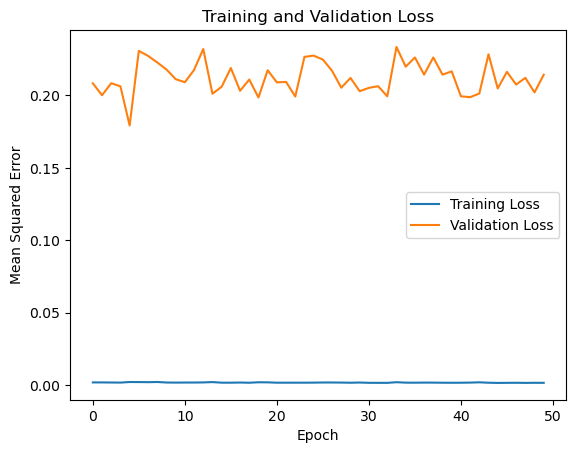

In [69]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [70]:
test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on test set: {test_mse}")


Mean Squared Error on test set: 0.21428589522838593
